In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

C:\Users\K Madhumitha\AppData\Local\Temp\ipykernel_7456\825037692.py:4: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit, transpile


Initial state of qubit 0:


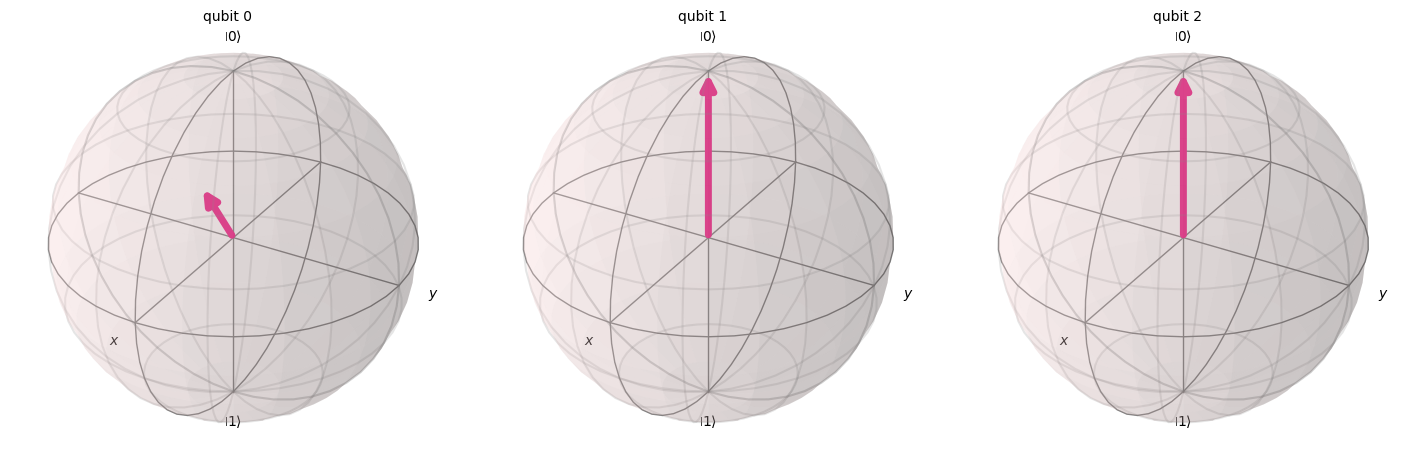

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


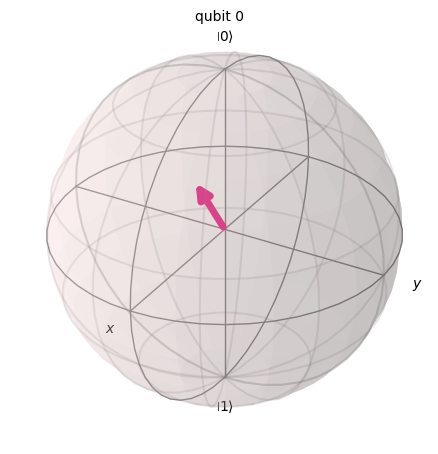

In [2]:
# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace
from qiskit.visualization import plot_bloch_multivector

def run_teleportation(theta, phi, use_classical_measurement=False, visualize_steps=False):
    qc = QuantumCircuit(3, 2 if use_classical_measurement else 0)

    qc.ry(theta, 0)
    qc.rz(phi, 0)
    if visualize_steps:
        state = Statevector.from_instruction(qc)
        plot_bloch_multivector(state, [0])
        plt.title("State preparation")
        plt.show()

    qc.h(1)
    qc.cx(1, 2)
    if visualize_steps:
        state = Statevector.from_instruction(qc)
        plot_bloch_multivector(state, [1, 2])
        plt.title("Bell pair creation")
        plt.show()

    qc.cx(0, 1)
    qc.h(0)
    if visualize_steps:
        state = Statevector.from_instruction(qc)
        plot_bloch_multivector(state, [0, 1])
        plt.title("Bell measurement basis change")
        plt.show()

    if use_classical_measurement:
        qc.measure([0, 1], [0, 1])
        # No QASM simulation without Aer, just show probs
        state = Statevector.from_instruction(qc)
        probs = state.probabilities_dict()
        print("Measurement result probabilities:", probs)
        return probs, None
    else:
        qc.cz(0, 2)
        qc.cx(1, 2)
        if visualize_steps:
            state = Statevector.from_instruction(qc)
            plot_bloch_multivector(state, [2])
            plt.title("After coherent corrections")
            plt.show()

        final_state = Statevector.from_instruction(qc)
        # Correct approach: partial_trace to get Bob's reduced state (qubit 2)
        bob_reduced = partial_trace(final_state, [0, 1])
        original_circ = QuantumCircuit(1)
        original_circ.ry(theta, 0)
        original_circ.rz(phi, 0)
        original_state = Statevector.from_instruction(original_circ)
        fidelity = state_fidelity(original_state, bob_reduced)
        return fidelity, final_state

 Task 1: Custom State Teleportation

In [18]:
theta = np.pi / 4
phi = np.pi / 2
fidelity, final_state = run_teleportation(theta, phi)
print(f"Custom state teleportation fidelity: {fidelity}")

Custom state teleportation fidelity: 0.9999999999999999


Task 2: Classical Measurement (Probabilities)

In [27]:
def run_teleportation(theta, phi, use_classical_measurement=False, visualize_steps=False):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    if use_classical_measurement:
        # Don't add .measure() to the circuit
        state = Statevector.from_instruction(qc)
        # Probabilities for all basis states
        probs = state.probabilities_dict()
        print("Measurement result probabilities:", probs)
        return probs, None
    else:
        qc.cz(0, 2)
        qc.cx(1, 2)
        final_state = Statevector.from_instruction(qc)
        bob_reduced = partial_trace(final_state, [0, 1])
        original_circ = QuantumCircuit(1)
        original_circ.ry(theta, 0)
        original_circ.rz(phi, 0)
        original_state = Statevector.from_instruction(original_circ)
        fidelity = state_fidelity(original_state, bob_reduced)
        return fidelity, final_state
print("Custom state teleportation fidelity:", fidelity)

Custom state teleportation fidelity: 0.9999999999999999


Task 3: Fidelity Analysis (Random States)

In [20]:
num_samples = 10
fidelities = []
for _ in range(num_samples):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    f, _ = run_teleportation(theta, phi)
    fidelities.append(f)
print(f"Average fidelity over {num_samples} random states:", np.mean(fidelities))

Average fidelity over 10 random states: 0.9999999999999997


Task 4: Step-by-Step Visualization

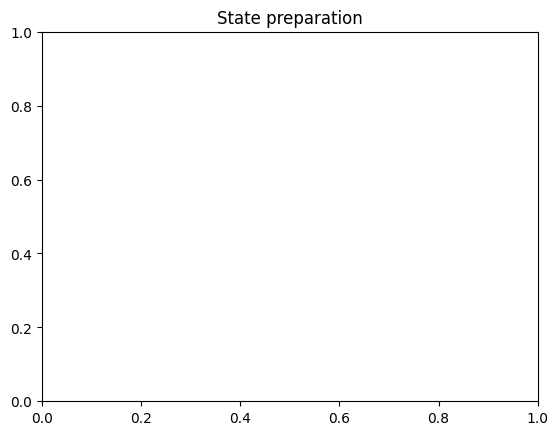

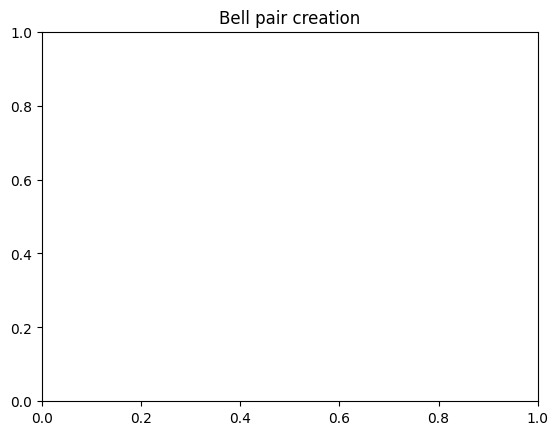

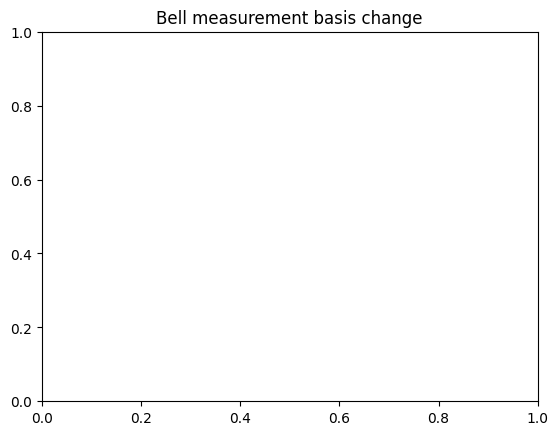

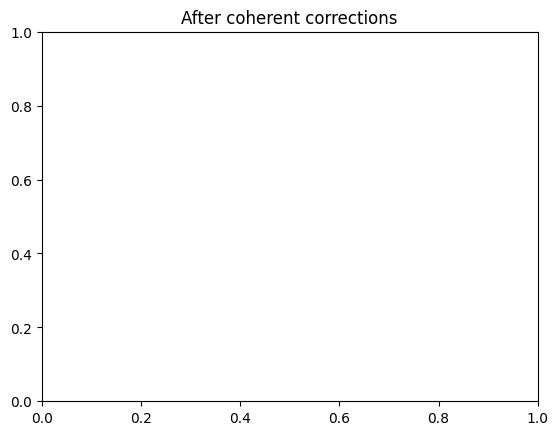

(0.9999999999999996,
 Statevector([ 0.41825815-0.11207193j,  0.41825815-0.11207193j,
               0.41825815-0.11207193j, -0.41825815+0.11207193j,
               0.24148146+0.06470476j,  0.24148146+0.06470476j,
               0.24148146+0.06470476j, -0.24148146-0.06470476j],
             dims=(2, 2, 2)))

In [21]:
theta = np.pi / 3
phi = np.pi / 6
run_teleportation(theta, phi, visualize_steps=True)

Task 5: Noise Simulation 

In [22]:
print("Task 5 (Noise): Skipped, as noise simulation is not possible without Aer.")

Task 5 (Noise): Skipped, as noise simulation is not possible without Aer.
